In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

from src.config import load_config

import polars as pl
import geopandas as gpd
import pandas as pd

import src.urban_tools as ut
import src.plot.cities as plc

## Load Config

In [3]:
config = load_config(ROOT / "config" / "paper.yaml")

In [4]:
h3_df = (
    pd.concat([gpd.read_parquet(city.h3_file).assign(city=city.name) for city in config.Cities], axis=0)
    .query("is_city")
)

h3_df.head()

geometry  is_city  \
region_id                                                                     
892a339a5afffff  POLYGON ((-71.13572 42.23376, -71.13794 42.232...     True   
892a3066a3bffff  POLYGON ((-71.08114 42.30902, -71.08337 42.308...     True   
892a302a567ffff  POLYGON ((-70.82381 42.36269, -70.82604 42.361...     True   
892a3066e17ffff  POLYGON ((-71.06072 42.33323, -71.06295 42.332...     True   
892a3066b3bffff  POLYGON ((-71.06614 42.29023, -71.06837 42.289...     True   

                        city  
region_id                     
892a339a5afffff  Boston, USA  
892a3066a3bffff  Boston, USA  
892a302a567ffff  Boston, USA  
892a3066e17ffff  Boston, USA  
892a3066b3bffff  Boston, USA

In [5]:
h3_df.groupby('city').nunique()

geometry  is_city
city                                
Austin, USA            6978        1
Boston, USA            2497        1
Brussels, Belgium      1916        1
Chicago, USA           6117        1
London, UK             6966        1
Seattle, USA           4203        1

## load embeddings

In [6]:
# embeddings = pd.read_parquet(config.GeoVex.embedding_file)
embeddings = pd.read_parquet(
    ROOT / "data/geovex/embeddings.parquet"
)

In [7]:
embeddings.head()

0          1         2         3          4   \
region_id                                                             
89489e32e07ffff  5.600688 -10.231544  3.097486 -3.269120   2.544040   
89195db490bffff  0.989876  -6.685911  0.513061 -4.106475   2.363695   
89194ada593ffff -7.635238  -0.822182  2.934359 -2.679239  11.052442   
892664d833bffff  6.484596  -9.474544  7.492222 -2.136434   1.466200   
891fa44f5d3ffff  0.159517  -4.280761  2.305098  2.769855   8.714569   

                        5          6         7         8         9   ...  \
region_id                                                            ...   
89489e32e07ffff   8.719959   0.694394 -1.331203  0.846226  3.695431  ...   
89195db490bffff   0.814430  -3.136031 -5.947582 -0.036014 -6.555581  ...   
89194ada593ffff -10.152945 -12.900042 -9.398361 -1.986774 -4.913168  ...   
892664d833bffff   3.027245  -3.390421 -7.959596 -1.734039  0.313618  ...   
891fa44f5d3ffff  -5.343400 -11.347857 -7.590637  7.004583 -5.661011  ...   

                        40        41        42         43         44  \
region_id                                                              
89489e32e07ffff  -1.126977 -2.297012 -6.301869 -11.016739   1.951841   
89195db490bffff   0.797358 -5.023606 -0.164264   0.396529   8.117504   
89194ada593ffff   3.923904 -3.128486  7.710240  11.062936  18.017612   
892664d833bffff   4.574410 -2.343295 -2.349093  -8.867690   2.372810   
891fa44f5d3ffff -11.839276  3.724287  8.660284  -3.572242   9.615739   

                       45        46         47        48         49  
region_id                                                            
89489e32e07ffff -0.051320 -5.273785   4.243793 -1.958380  14.360164  
89195db490bffff  4.769056 -4.654082   5.657088 -1.479651   5.395323  
89194ada593ffff  7.878415 -5.225205   0.748481 -3.911448 -10.463480  
892664d833bffff -5.627240 -4.146455  10.451908 -0.135918  -1.581743  
891fa44f5d3ffff  4.260943 -7.172214  -3.170409 -4.958455   3.493499  

[5 rows x 50 columns]

## Load clusters

In [8]:
clusters_df = pd.read_parquet(
    config.GeoVex.cluster_file
)

clusters_df = clusters_df.rename(columns={"region_id":"h3"})

In [9]:
clusters_df.head()

h3         city  cluster
0  892a339a5afffff  Boston, USA        0
1  892a3066a3bffff  Boston, USA        0
2  892a3066e17ffff  Boston, USA        3
3  892a3066b3bffff  Boston, USA        0
4  892a3066803ffff  Boston, USA        0

## Load population

In [10]:
pop_df = (
    pd.concat([gpd.read_parquet(city.pop_file) for city in config.Cities], axis=0)
)

pop_df.head()

h3                                           geometry  \
0  892a302924bffff  POLYGON ((-71.03373 42.35474, -71.03596 42.353...   
1  892a3064663ffff  POLYGON ((-71.15091 42.34658, -71.15314 42.345...   
2  892a30282afffff  POLYGON ((-70.93289 42.32786, -70.93512 42.326...   
3  892a3393667ffff  POLYGON ((-71.05783 42.26874, -71.06006 42.267...   
4  892a30286b3ffff  POLYGON ((-70.91239 42.35204, -70.91462 42.351...   

          city  population  
0  Boston, USA    0.000000  
1  Boston, USA  907.630063  
2  Boston, USA    0.000000  
3  Boston, USA   26.857052  
4  Boston, USA    0.000000

## Load OSM tags

In [11]:
count_df_file = ROOT / "data" / "geovex" / "count.parquet"

if count_df_file.exists():
    count_df = pl.read_parquet(count_df_file)
    count_df = count_df.rename({"region_id":"h3"})

In [12]:
osm_category_df = ut.map_tags_to_categories(count_df.to_pandas())

Tags mapped to 'Other': []


Unmatched columns: set()


In [13]:
osm_category_df.head()

Amenities Built Environment Commerce and Industry Historical and Cultural  \
0         0                 0                     0                       0   
1         0                30                     0                       0   
2         0                 0                     0                       0   
3         1                81                     0                       1   
4         0                 0                     0                       0   

  Leisure and Recreation Natural Elements Transportation         city  \
0                      0                0              0  Boston, USA   
1                      0                0              3  Boston, USA   
2                      0                0              0  Boston, USA   
3                      1                0             31  Boston, USA   
4                      2                3              4  Boston, USA   

                h3  
0  892a3029a33ffff  
1  892a3065c8fffff  
2  892a302b077ffff  
3  892a3067227ffff  
4  892a339146fffff

## Merge dfs

In [14]:
merged_df = ut.merge_pop_with_categories(pop_df,osm_category_df,clusters_df)

In [15]:
merged_df = merged_df.query("cluster!=-1")

In [16]:
merged_df.head()

h3                                           geometry  \
1   892a3064663ffff  POLYGON ((-71.15091 42.34658, -71.15314 42.345...   
3   892a3393667ffff  POLYGON ((-71.05783 42.26874, -71.06006 42.267...   
7   892a3074b8bffff  POLYGON ((-71.01287 42.39509, -71.01510 42.394...   
9   892a3064b77ffff  POLYGON ((-71.13311 42.25256, -71.13533 42.251...   
12  892a306642bffff  POLYGON ((-71.05075 42.38163, -71.05298 42.380...   

           city  population Amenities Built Environment Commerce and Industry  \
1   Boston, USA  907.630063         6               206                     0   
3   Boston, USA   26.857052         0                 6                     0   
7   Boston, USA   30.772454         3                 6                     0   
9   Boston, USA  666.955735         2               190                     0   
12  Boston, USA  181.007065         6                13                     2   

   Historical and Cultural Leisure and Recreation Natural Elements  \
1                        1                      6                0   
3                        0                      1                2   
7                        0                      2                1   
9                        0                      0                0   
12                       0                      3                0   

   Transportation  cluster  
1              52      0.0  
3               2      0.0  
7              56      2.0  
9              16      0.0  
12             69      2.0

## Boston analysis

/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis/src/plot/cities.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


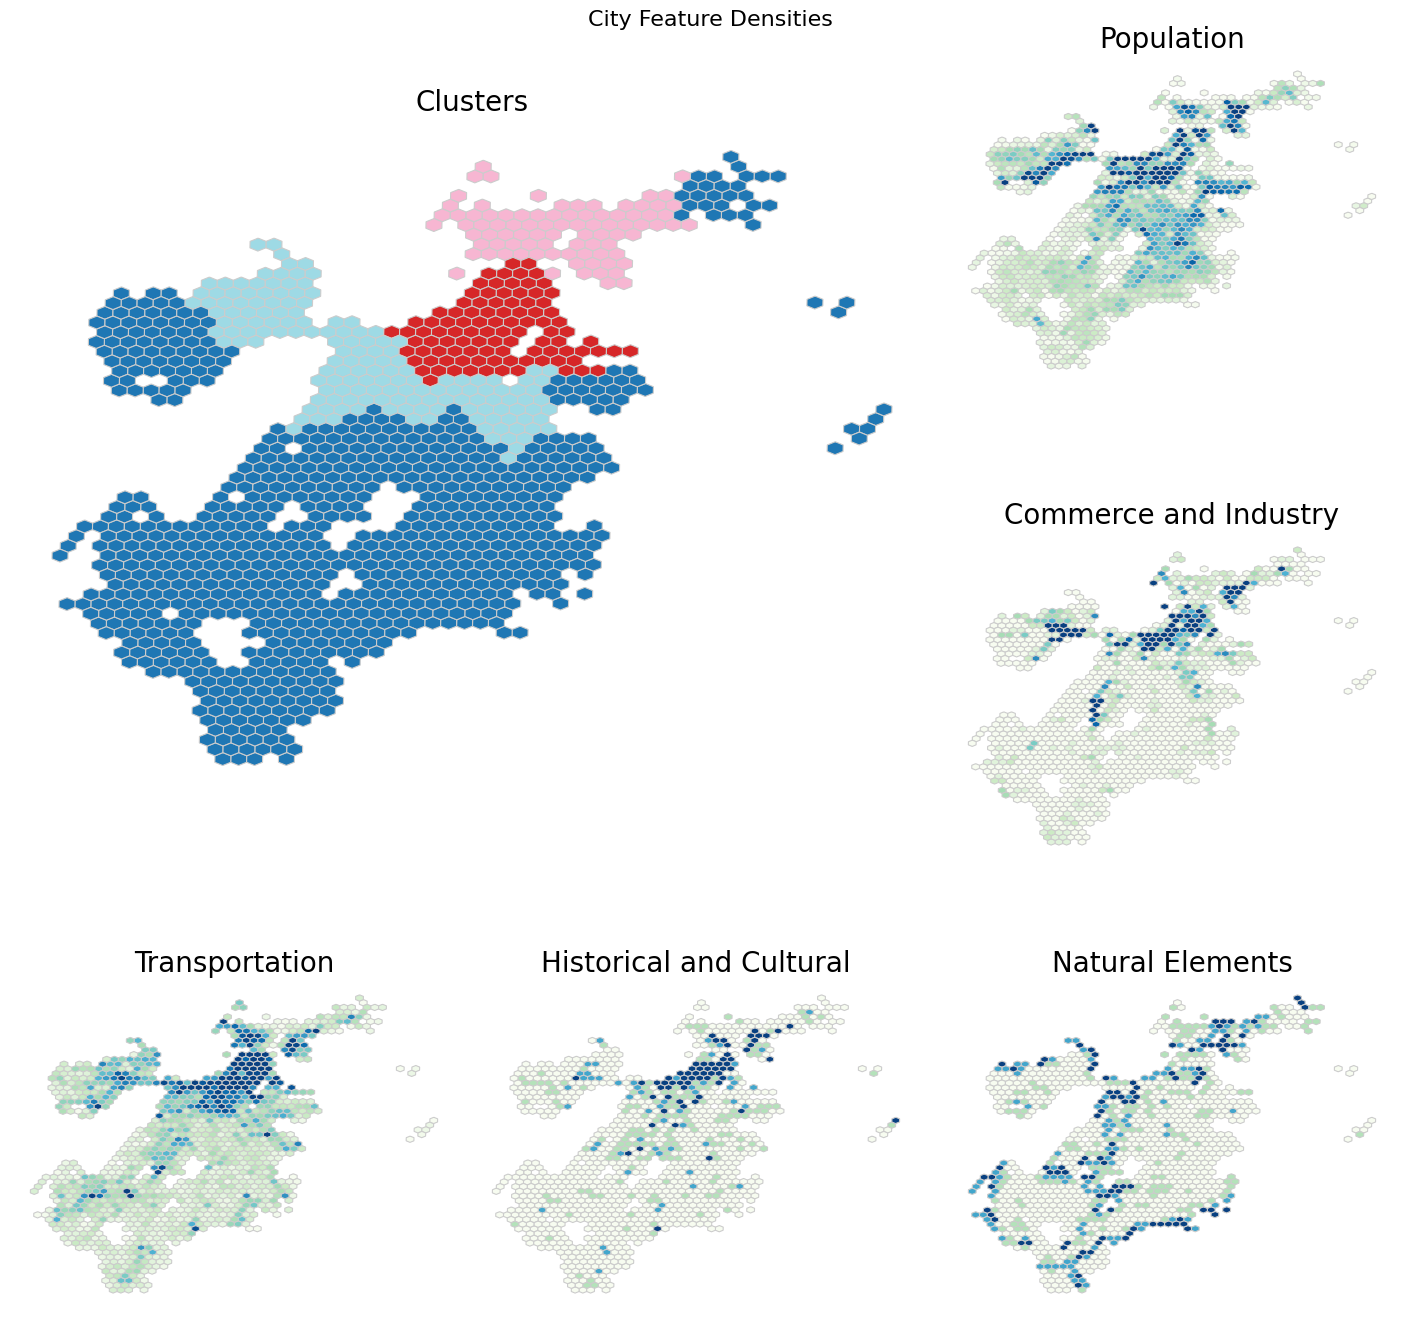

In [17]:
city_data = merged_df.query("city=='Boston, USA'").copy()
out = plc.multi_plot_city_feature_density(city_data)

In [18]:
hex_counts = city_data.groupby('cluster')['h3'].count().reset_index(name='hex_count')
tags = city_data[city_data.columns[3:]].groupby('cluster').mean()

In [19]:
boston_clusters = pd.merge(hex_counts,tags,left_on='cluster',right_index=True)

In [20]:
boston_clusters

cluster  hex_count  population  Amenities Built Environment  \
0      0.0        795  472.959797   3.303145        111.046541   
1      1.0         98  819.480999  34.255102        105.438776   
2      2.0         87  554.614393  12.344828         91.873563   
3      3.0        159  752.180942  13.176101         75.886792   

  Commerce and Industry Historical and Cultural Leisure and Recreation  \
0              0.446541                0.220126               2.367296   
1              4.336735                1.561224               7.928571   
2              2.229885                0.712644                4.83908   
3              2.018868                0.540881                5.45283   

  Natural Elements Transportation  
0         0.607547       50.33522  
1          0.72449     180.112245  
2         1.172414      99.305747  
3         0.685535     107.060377

In [23]:
import matplotlib.pyplot as plt

/var/folders/66/24n_29v55jj2r9b1fvnxx43h0000gn/T/ipykernel_25679/1008958242.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", 4)


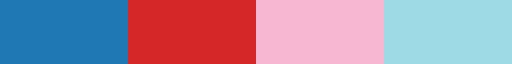

In [26]:
cmap = plt.cm.get_cmap("tab20", 4)
cmap

## Seattle

/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis/src/plot/cities.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


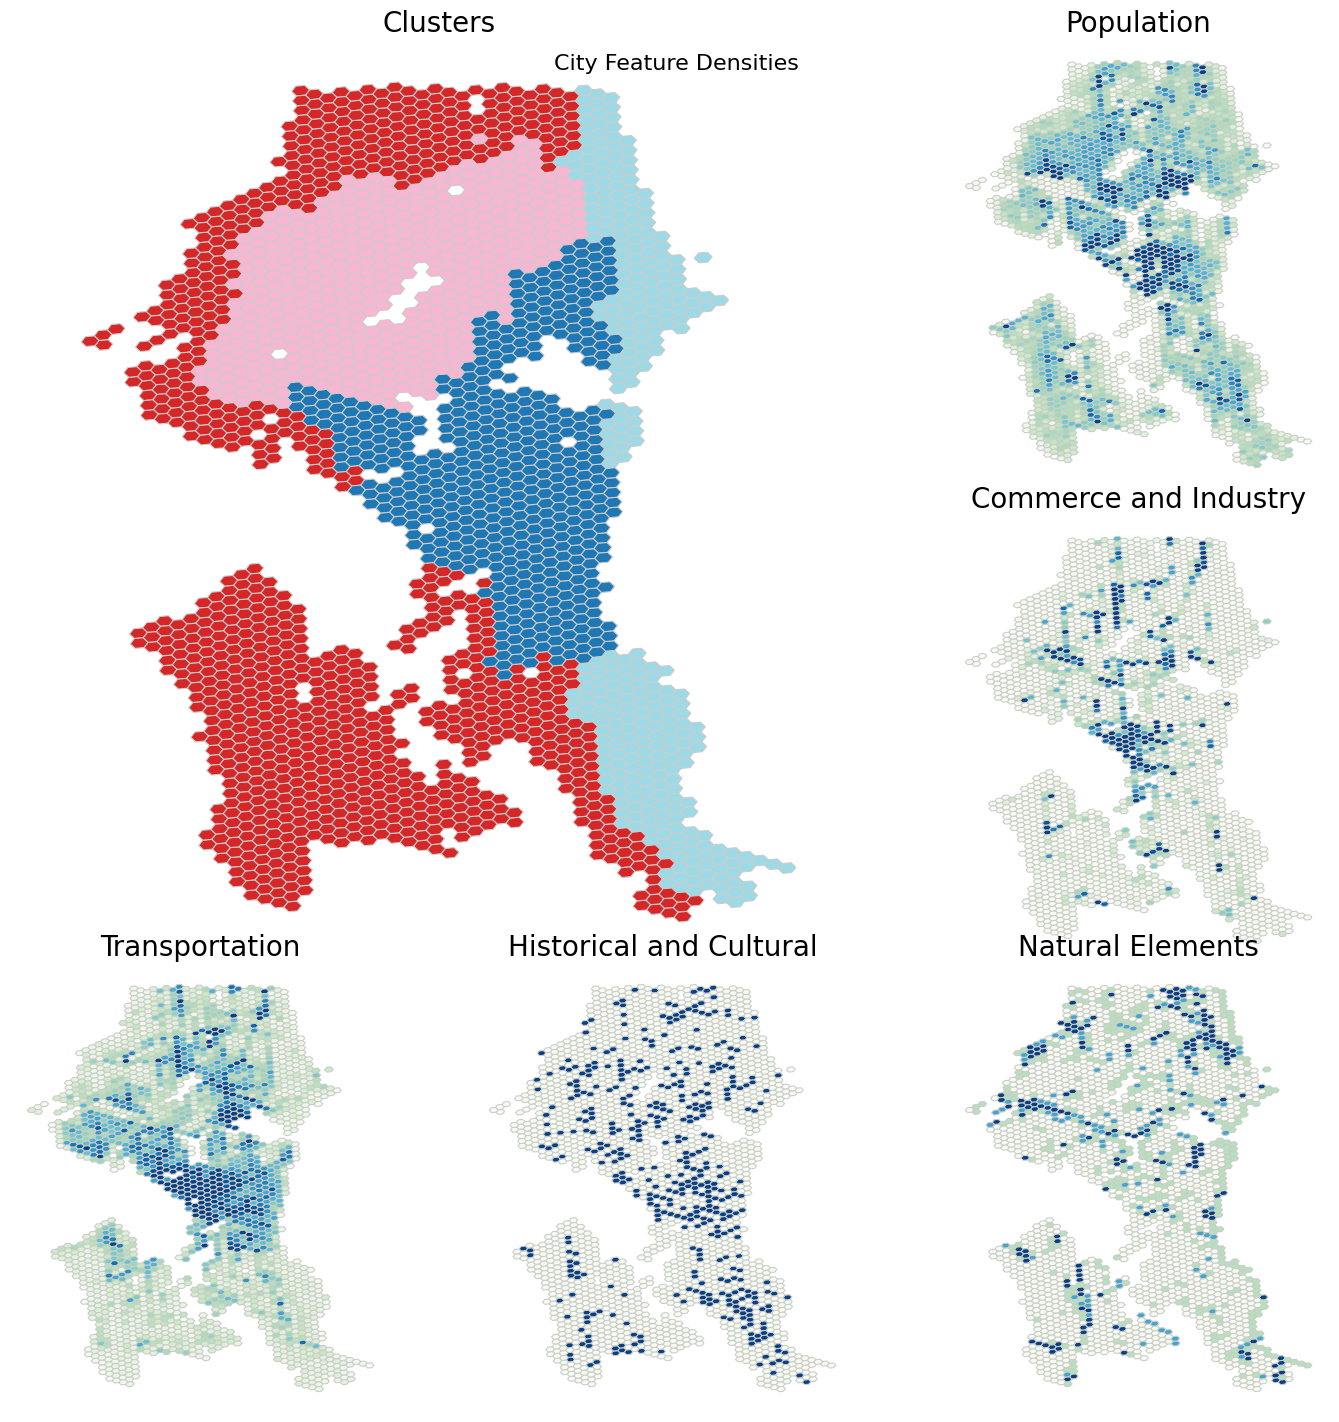

In [27]:
city_data = merged_df.query("city=='Seattle, USA'").copy()
out = plc.multi_plot_city_feature_density(city_data)

In [28]:
hex_counts = city_data.groupby('cluster')['h3'].count().reset_index(name='hex_count')
tags = city_data[city_data.columns[3:]].groupby('cluster').mean()

In [29]:
seattle_clusters = pd.merge(hex_counts,tags,left_on='cluster',right_index=True)

In [30]:
seattle_clusters

cluster  hex_count  population  Amenities Built Environment  \
0      0.0        497  349.960022  15.118712        104.008048   
1      1.0        981  204.572781   3.723751         87.989806   
2      2.0        473  339.741966  10.591966        136.511628   
3      3.0        325  232.066071   2.538462         94.741538   

  Commerce and Industry Historical and Cultural Leisure and Recreation  \
0              3.297787                0.299799               3.344064   
1              1.383792                0.130479               1.834862   
2              3.316068                 0.22833               2.835095   
3              0.810769                0.175385               2.089231   

  Natural Elements Transportation  
0         0.579477     149.177062  
1         0.517839      59.601427  
2         0.570825     102.139535  
3         0.670769      39.313846

## Austin

/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis/src/plot/cities.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


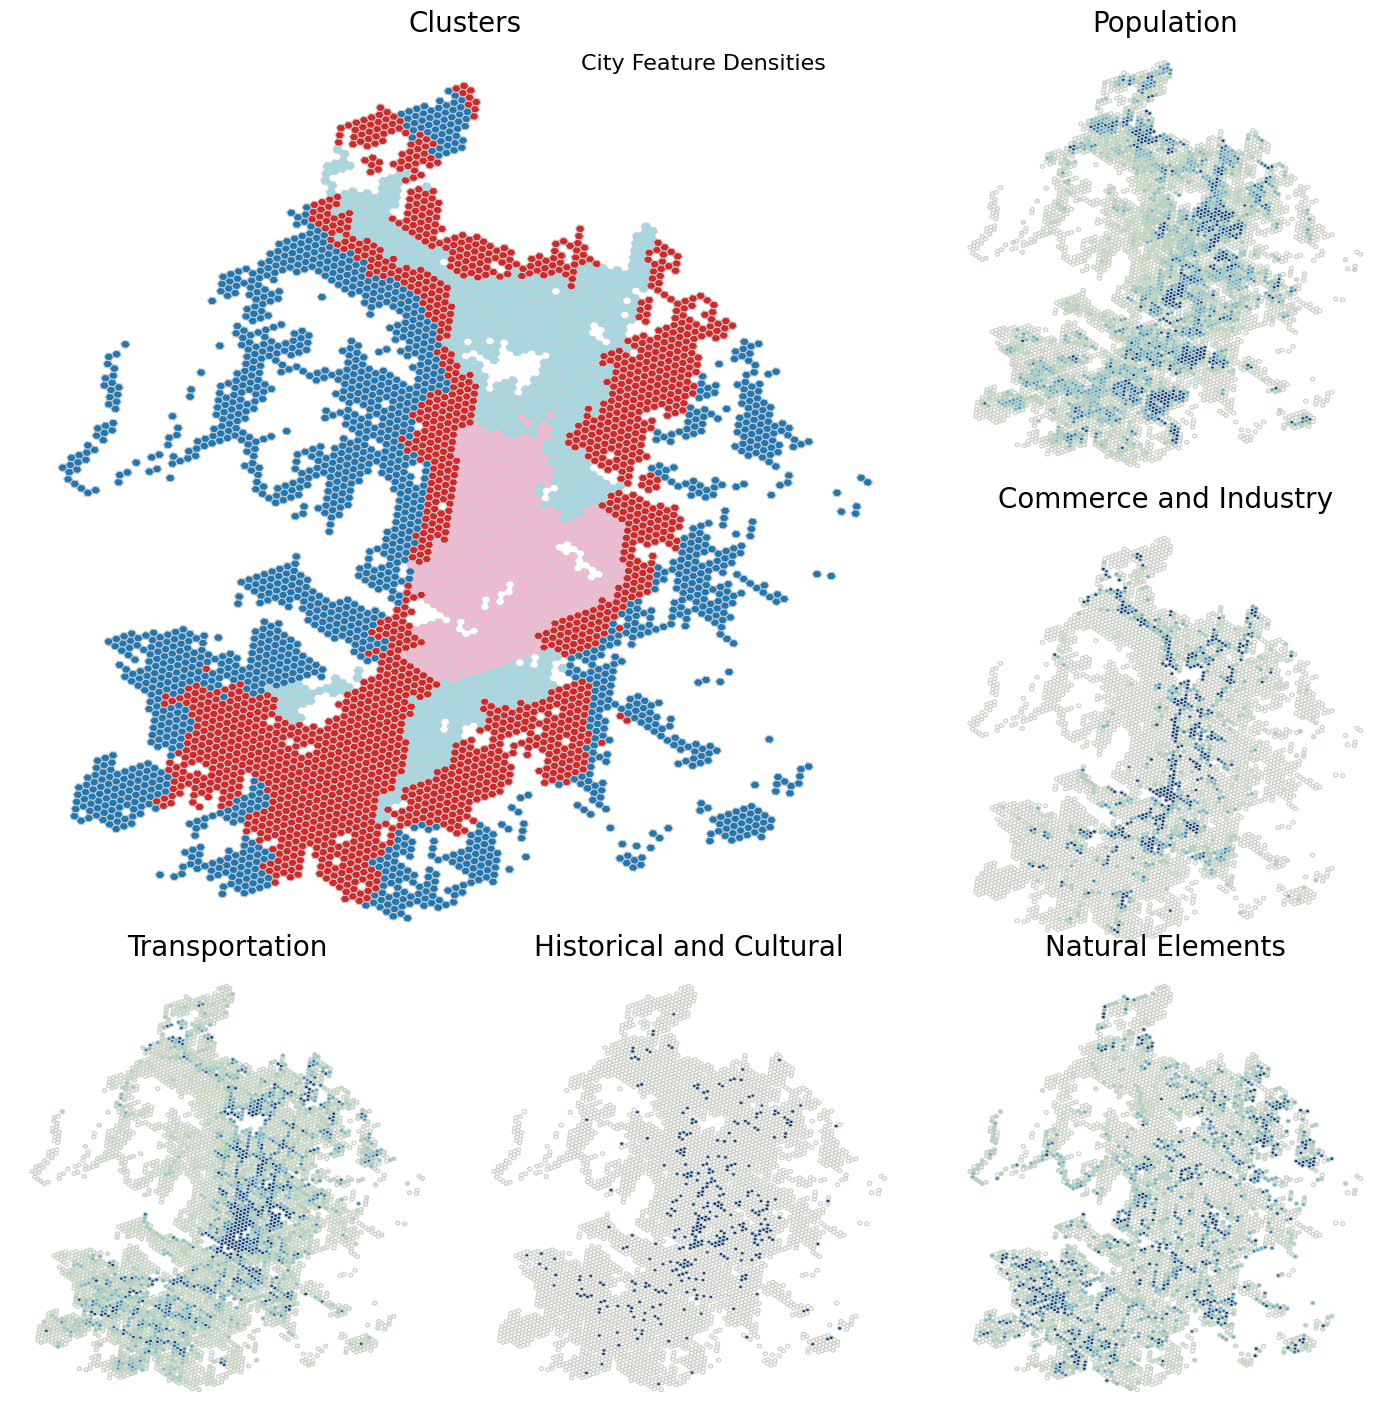

In [23]:
city_data = merged_df.query("city=='Austin, USA'").copy()
out = plc.multi_plot_city_feature_density(city_data)

In [24]:
hex_counts = city_data.groupby('cluster')['h3'].count().reset_index(name='hex_count')
tags = city_data[city_data.columns[3:]].groupby('cluster').mean()

In [25]:
austin_clusters = pd.merge(hex_counts,tags,left_on='cluster',right_index=True)

## Chicago

/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis/src/plot/cities.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


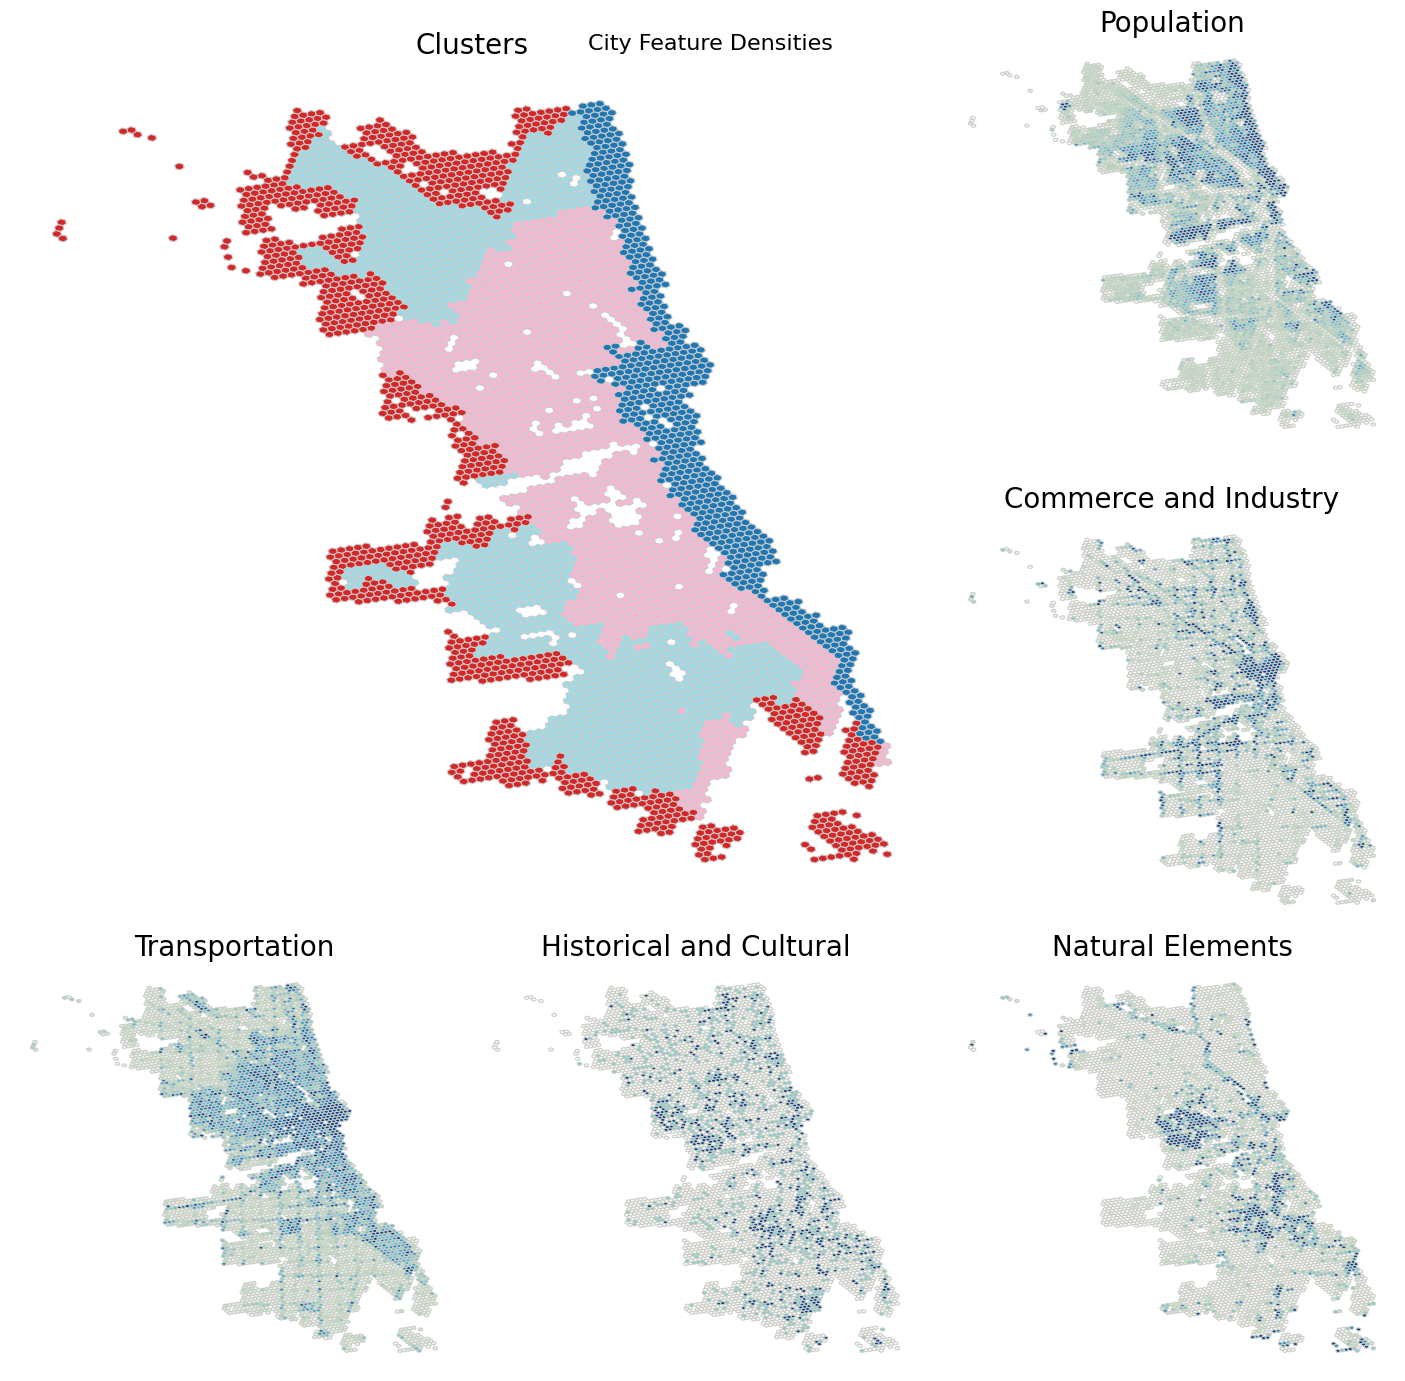

In [26]:
city_data = merged_df.query("city=='Chicago, USA'").copy()
out = plc.multi_plot_city_feature_density(city_data)

In [27]:
hex_counts = city_data.groupby('cluster')['h3'].count().reset_index(name='hex_count')
tags = city_data[city_data.columns[3:]].groupby('cluster').mean()

In [28]:
chicago_clusters = pd.merge(hex_counts,tags,left_on='cluster',right_index=True)

## Brussels

/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis/src/plot/cities.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


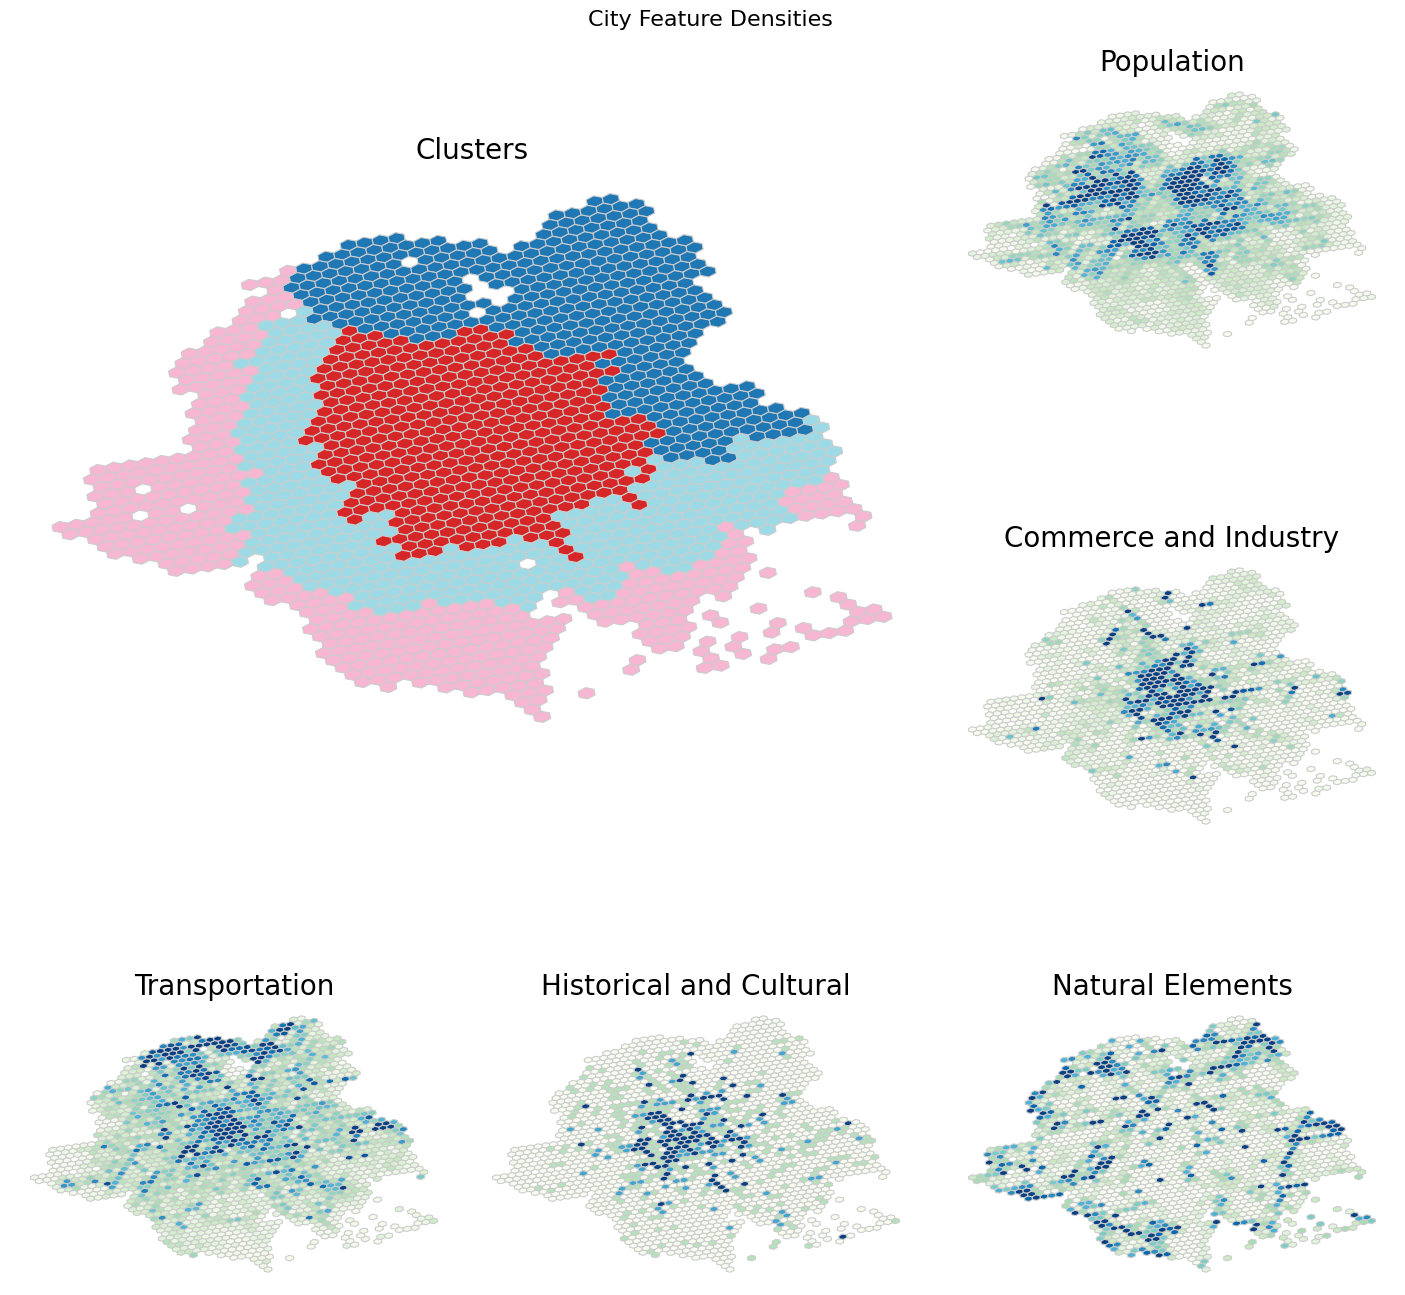

In [41]:
city_data = merged_df.query("city=='Brussels, Belgium'").copy()
out = plc.multi_plot_city_feature_density(city_data)

In [42]:
hex_counts = city_data.groupby('cluster')['h3'].count().reset_index(name='hex_count')
tags = city_data[city_data.columns[3:]].groupby('cluster').mean()

In [43]:
brussels_clusters = pd.merge(hex_counts,tags,left_on='cluster',right_index=True)

## London

/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis/src/plot/cities.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


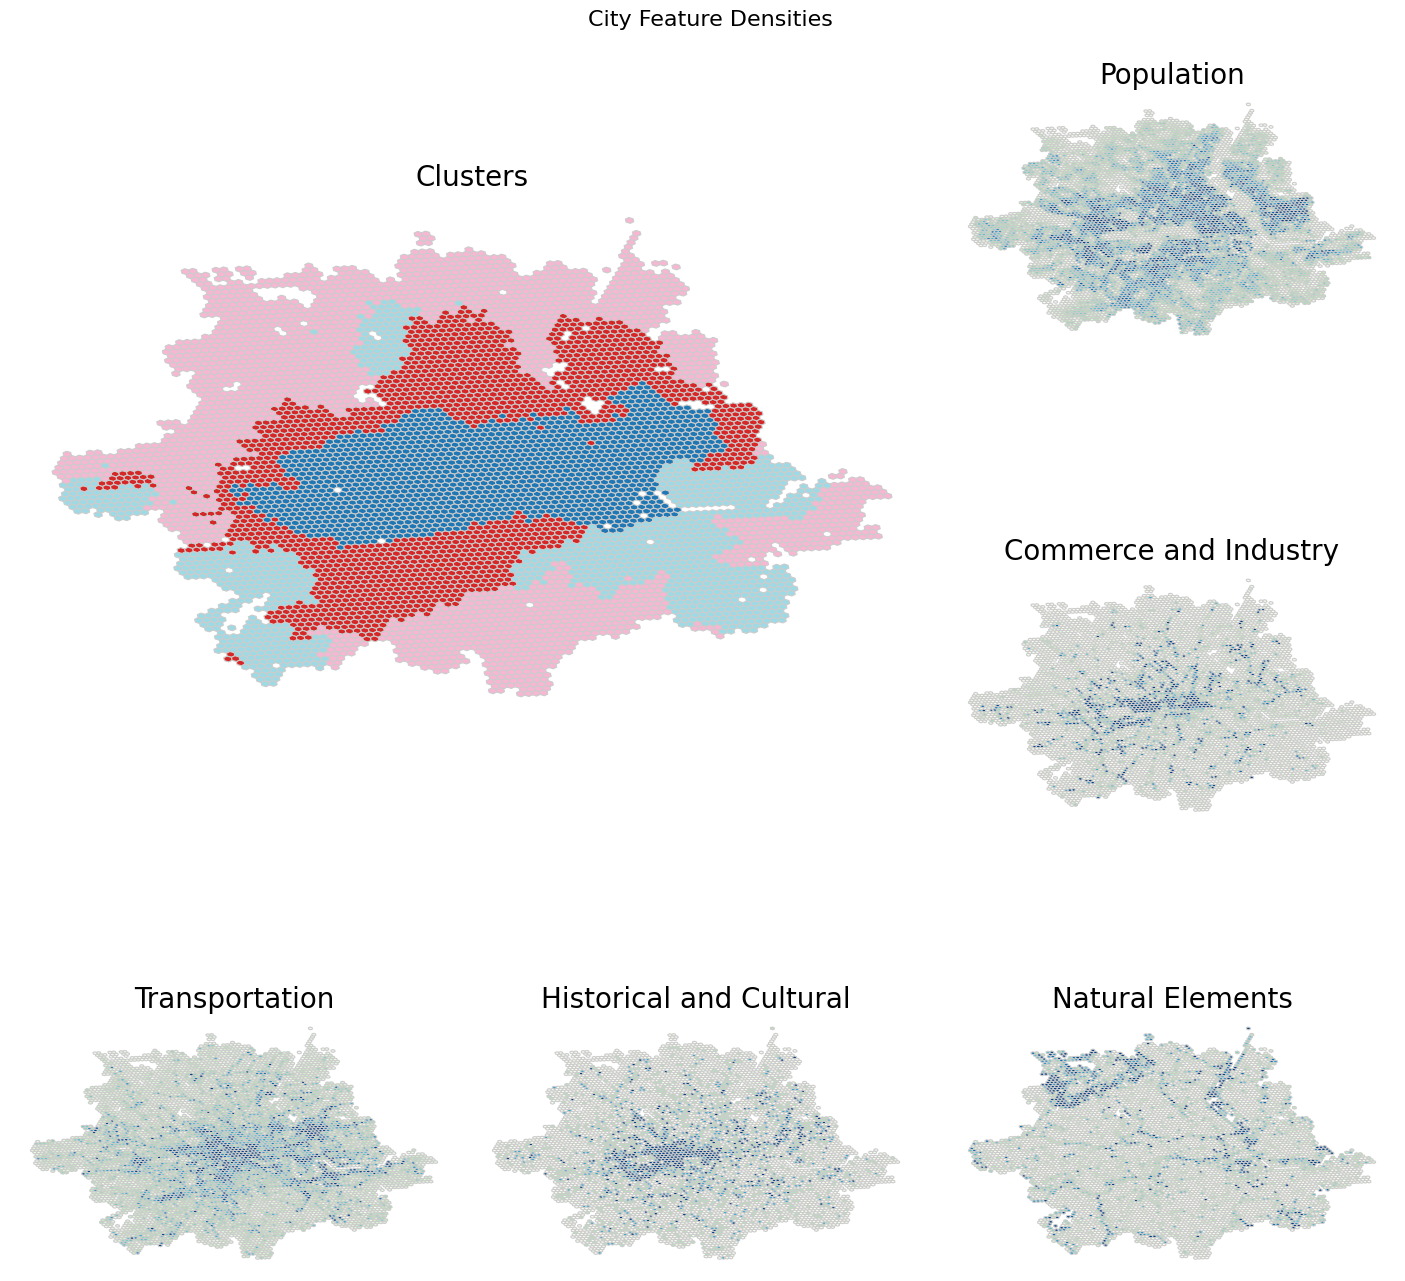

In [31]:
city_data = merged_df.query("city=='London, UK'").query("cluster>-1").copy()
out = plc.multi_plot_city_feature_density(city_data)

In [32]:
hex_counts = city_data.groupby('cluster')['h3'].count().reset_index(name='hex_count')
tags = city_data[city_data.columns[3:]].groupby('cluster').mean()

In [33]:
london_clusters = pd.merge(hex_counts,tags,left_on='cluster',right_index=True)

## save city clusters

In [51]:
# create list of each city's clusters
cities = [boston_clusters,seattle_clusters,austin_clusters,chicago_clusters,brussels_clusters,london_clusters]
# list of city names
city_names = ['Boston','Seattle','Austin','Chicago','Brussels', 'London']
# add city column to each df
for city in enumerate(cities):
    city[1]['city'] = city_names[city[0]]

# merge dfs of all city clusters
all_clusters = pd.concat([boston_clusters,seattle_clusters,austin_clusters,chicago_clusters,brussels_clusters, london_clusters], axis=0)

In [52]:
all_clusters

cluster  hex_count   population  Amenities Built Environment  \
0      0.0        795   472.959797   3.303145        111.046541   
1      1.0         98   819.480999  34.255102        105.438776   
2      2.0         87   554.614393  12.344828         91.873563   
3      3.0        159   752.180942  13.176101         75.886792   
0      0.0        497   349.960022  15.118712        104.008048   
1      1.0        981   204.572781   3.723751         87.989806   
2      2.0        473   339.741966  10.591966        136.511628   
3      3.0        325   232.066071   2.538462         94.741538   
0      0.0       1889   103.402322   0.617787         39.766543   
1      1.0       1804   219.412045   1.359202          78.81153   
2      2.0        620   270.020552   6.385484        116.912903   
3      3.0        809   255.251887    3.68356         67.972806   
0      0.0        600   687.539796  12.743333        102.423333   
1      1.0       1132   349.805646    2.44523         165.80742   
2      2.0       1622   578.550898   5.165228        195.382244   
3      3.0       1448   493.628698   2.946133        233.368785   
0      0.0        416   580.661442    15.3125        119.985577   
1      1.0        427  1254.582388  31.564403        268.468384   
2      2.0        468   351.356567   4.596154          98.57265   
3      3.0        427   669.439828   9.611241         168.58548   
0      0.0       1331  1143.249840  33.601052        133.789632   
1      1.0       1671  1036.780077  14.116697        133.421903   
2      2.0       2415   622.257195   5.137888         56.464182   
3      3.0       1202   621.960406  10.178869        126.135607   

  Commerce and Industry Historical and Cultural Leisure and Recreation  \
0              0.446541                0.220126               2.367296   
1              4.336735                1.561224               7.928571   
2              2.229885                0.712644                4.83908   
3              2.018868                0.540881                5.45283   
0              3.297787                0.299799               3.344064   
1              1.383792                0.130479               1.834862   
2              3.316068                 0.22833               2.835095   
3              0.810769                0.175385               2.089231   
0              0.203282                0.021705                1.13658   
1              0.560421                0.067627               1.617517   
2              1.470968                0.219355               2.741935   
3              1.814586                0.066749               1.893696   
0              4.123333                0.566667               5.633333   
1              1.764134                0.259717               1.717314   
2              2.776819                0.588163               2.061036   
3              1.952348                0.358425               1.707873   
0              2.805288                0.266827               5.834135   
1              8.925059                1.133489               6.880562   
2              1.042735                0.168803               4.489316   
3              2.175644                0.313817               5.601874   
0             11.855748                1.307288              10.296018   
1              6.101735                0.655895               6.610413   
2              2.034783                0.305176               2.721325   
3              3.809484                0.414309               8.262063   

  Natural Elements Transportation      city  
0         0.607547       50.33522    Boston  
1          0.72449     180.112245    Boston  
2         1.172414      99.305747    Boston  
3         0.685535     107.060377    Boston  
0         0.579477     149.177062   Seattle  
1         0.517839      59.601427   Seattle  
2         0.570825     102.139535   Seattle  
3         0.670769      39.313846   Seattle  
0         1.202223      16.031763    Austin  
1         1.4240

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

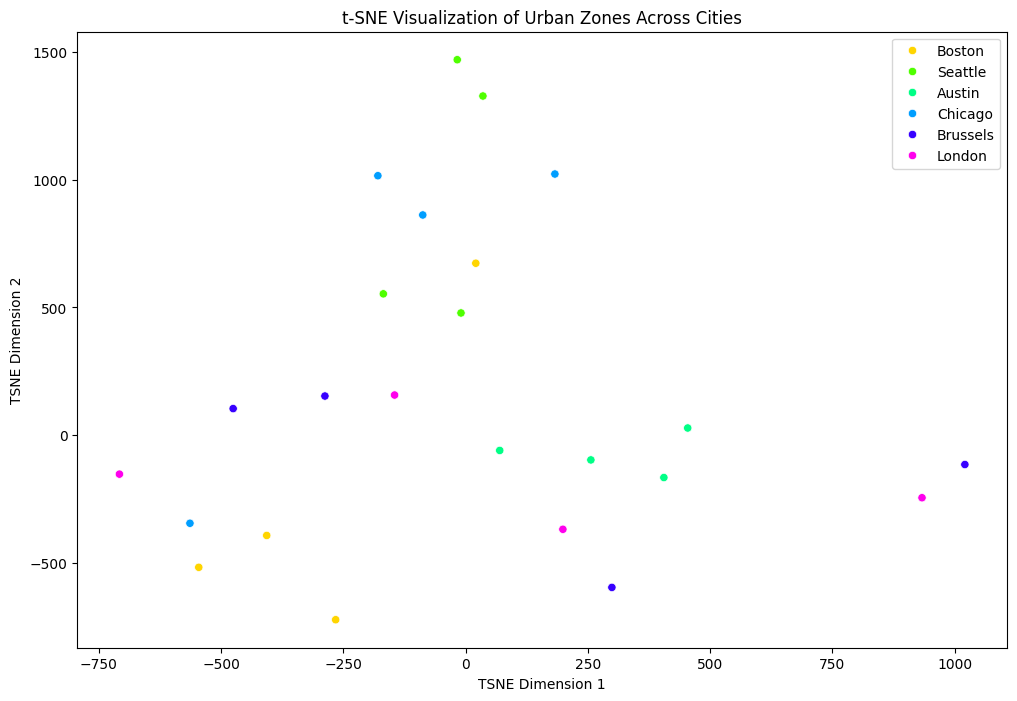

In [60]:
# Exclude 'Cluster' and 'Hex Count' columns
features = all_clusters.drop(['cluster', 'hex_count', 'city'], axis=1)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=5, learning_rate=200, random_state=0)
tsne_results = tsne.fit_transform(features_normalized)

# Prepare the data for visualization
df_tsne = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])

all_clusters.reset_index(drop=True, inplace=True)
df_tsne.reset_index(drop=True, inplace=True)

df_tsne['City'] = all_clusters['city']

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x="TSNE1", y="TSNE2", hue="City", palette=sns.color_palette("hsv", len(df_tsne['City'].unique())), data=df_tsne)
plt.title('t-SNE Visualization of Urban Zones Across Cities')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.legend()
plt.show()


city  cluster      centroid_h3
0         Austin, USA        0  89489e265d7ffff
1         Austin, USA        1  89489eace2fffff
2         Austin, USA        2  89489e35a87ffff
3         Austin, USA        3  89489e25003ffff
4         Boston, USA        0  892a30648afffff
5         Boston, USA        1  892a30663a3ffff
6         Boston, USA        2  892a30664a7ffff
7         Boston, USA        3  892a3064097ffff
8   Brussels, Belgium        0  891fa44e417ffff
9   Brussels, Belgium        1  891fa441b5bffff
10  Brussels, Belgium        2  891fa44f2d7ffff
11  Brussels, Belgium        3  891fa44f193ffff
12       Chicago, USA        0  892664cf527ffff
13       Chicago, USA        1  892664562abffff
14       Chicago, USA        2  892664cdc93ffff
15       Chicago, USA        3  89266456683ffff
16         London, UK        0  89194ad358bffff
17         London, UK        1  89195da686bffff
18         London, UK        2  89194e69693ffff
19         London, UK        3  89194ad2ebbffff
20       Seattle, USA        0  8928d542507ffff
21       Seattle, USA        1  8928d5452b3ffff
22       Seattle, USA        2  8928d547653ffff
23       Seattle, USA        3  8928d55016bffff

In [73]:
ROOT

PosixPath('/Users/nicolascollignon/kalecollective/greenlastmile/cargo-bike-analysis')